In [8]:

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

plt.rc("figure", dpi=100)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [10]:
def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape).to(device) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


In [11]:
class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])



In [12]:
# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [13]:
# initialize weights
# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)


optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 20

train_loss = []
test_loss = []

In [14]:
# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784).to(device)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y.to(device), reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 2 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784).to(device)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y.to(device), reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")



Epoch: 0
Mean Train Loss: 4.05e-01
Mean Test Loss:  1.90e-01
Epoch: 2
Mean Train Loss: 1.98e-01
Mean Test Loss:  2.22e-01
Epoch: 4
Mean Train Loss: 1.87e-01
Mean Test Loss:  2.50e-01
Epoch: 6
Mean Train Loss: 1.80e-01
Mean Test Loss:  2.33e-01
Epoch: 8
Mean Train Loss: 1.57e-01
Mean Test Loss:  2.57e-01
Epoch: 10
Mean Train Loss: 1.65e-01
Mean Test Loss:  4.71e-01
Epoch: 12
Mean Train Loss: 1.47e-01
Mean Test Loss:  2.98e-01
Epoch: 14
Mean Train Loss: 1.36e-01
Mean Test Loss:  3.04e-01
Epoch: 16
Mean Train Loss: 1.25e-01
Mean Test Loss:  3.63e-01
Epoch: 18
Mean Train Loss: 1.12e-01
Mean Test Loss:  5.21e-01
Epoch: 20
Mean Train Loss: 1.00e-01
Mean Test Loss:  5.46e-01


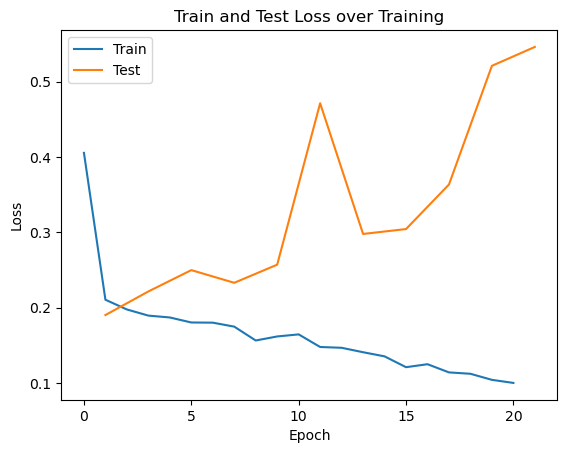

In [15]:
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 2), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


In [21]:
def dropout(X,p_drop=0.5):

    if p_drop > 1:
        return X

    mask = torch.bernoulli(torch.ones_like(X) * (1 - p_drop))
    return mask * X / (1 - p_drop)

In [22]:
def dropout_model(x, w_h, w_h2, w_o, p_drop_input=0.5,p_drop_hidden=0.5):
    x = dropout(x, p_drop_input)
    h = rectify(x @ w_h)
    h = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [23]:
# initialize weights
# input shape is (B, 784)
w_h_drop = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2_drop = init_weights((625, 625))
# hidden layer with 625 neurons
w_o_drop = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h_drop, w_h2_drop, w_o_drop])


n_epochs = 10

train_loss_drop = []
test_loss_drop = []

In [25]:
# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784).to(device)
        # feed input through model
        noise_py_x = dropout_model(x, w_h_drop, w_h2_drop, w_o_drop)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y.to(device), reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss_drop.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 2 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss_drop[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784).to(device)
                noise_py_x = dropout_model(x, w_h, w_h2, w_o,0,0)

                loss = cross_entropy(noise_py_x, y.to(device), reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss_drop.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss_drop[-1]:.2e}")



Epoch: 0
Mean Train Loss: 6.60e-01
Mean Test Loss:  5.46e-01
Epoch: 2
Mean Train Loss: 7.61e-01
Mean Test Loss:  5.46e-01
Epoch: 4
Mean Train Loss: 8.28e-01
Mean Test Loss:  5.46e-01
Epoch: 6
Mean Train Loss: 9.09e-01
Mean Test Loss:  5.46e-01
Epoch: 8
Mean Train Loss: 9.98e-01
Mean Test Loss:  5.46e-01
Epoch: 10
Mean Train Loss: 1.07e+00
Mean Test Loss:  5.46e-01


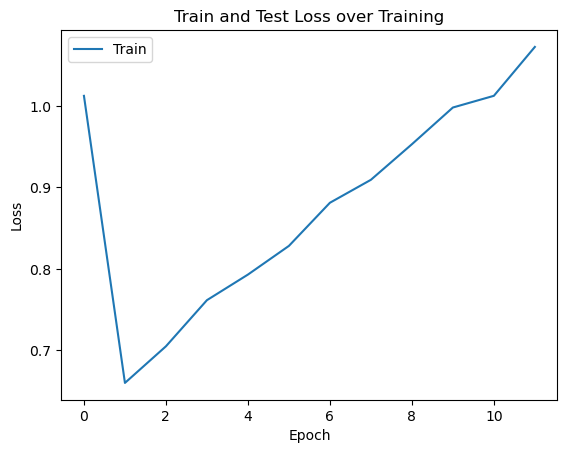

In [31]:
plt.plot(np.arange(n_epochs + 2), train_loss_drop, label="Train")
# plt.plot(np.arange(1, n_epochs + 2, 2), test_loss_drop, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


The dropout layer works by randomly deactivating certain neurons in the linear layers (or if applied to the input, deactivating certain features of the input vector). In this way the training load is more evenly distributed among the network, encourages diversity in the learned parameters and helps reduce redundancy i.e. neurons that do not significantly contribute to the performance of the network (cause of their existance can be attributed to overparametrization; see https://arxiv.org/abs/1503.02531, https://arxiv.org/abs/1803.03635).

In our implementation we use all the neurons for the testing to get the best accuracy, so in this sense this is Inverted Dropout not dropout. See: https://stackoverflow.com/questions/54109617/implementing-dropout-from-scratch

In [ ]:
## test error comparation
print("With dropout: {}".format(test_loss_drop[-1]))
print("Without dropout: {}".format(test_loss[-1]))

## interpretation: it makes sense that the dropout model needs more epochs to train to reach the same performance, but avoid overfitting.